In [2]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # For simplicity, using midpoint ODE solver in this example
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
        t_start + (t_end - t_start) / 2)

# training
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
from tqdm import  tqdm
for _ in tqdm(range(20000)):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()

# sampling

  5%|▍         | 990/20000 [00:10<03:27, 91.60it/s] 


KeyboardInterrupt: 

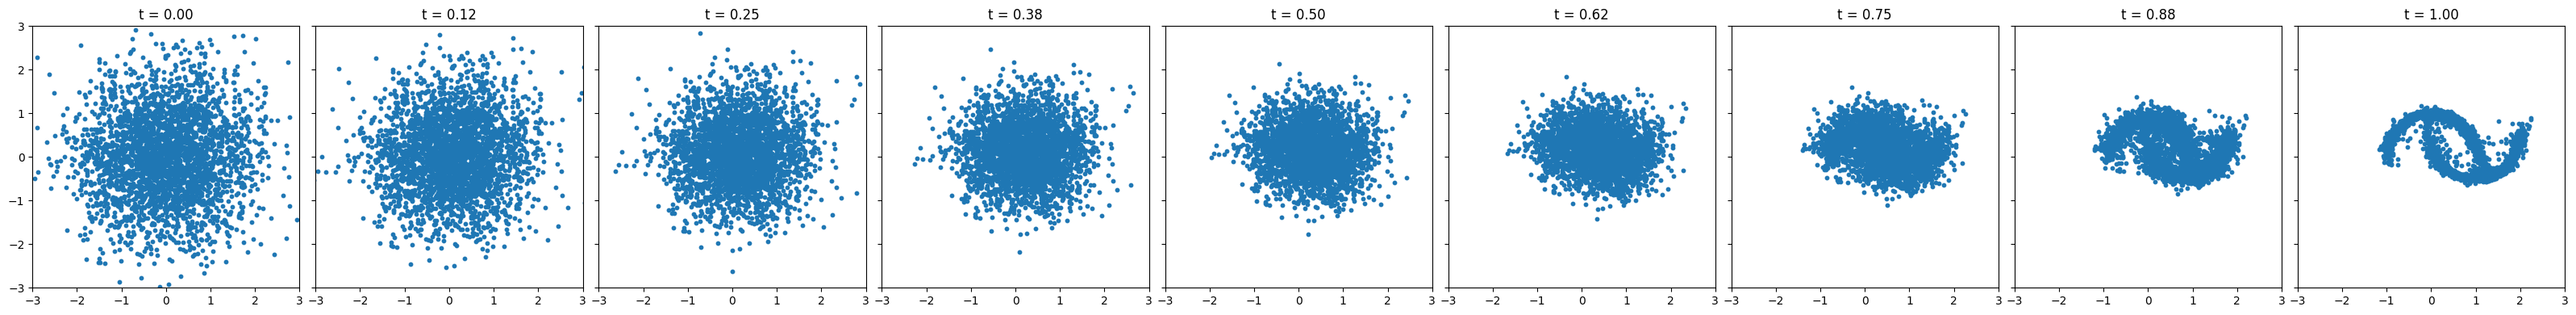

In [10]:
x = torch.randn(3000, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(32, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

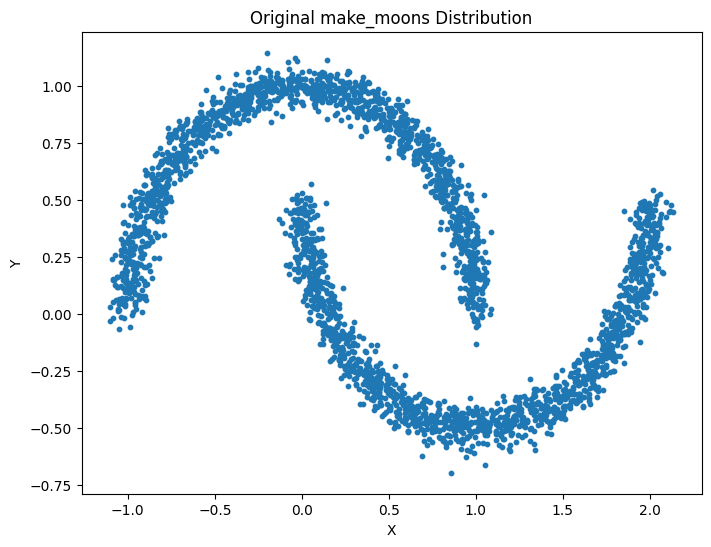

In [13]:
# Visualize the make_moons distribution
plt.figure(figsize=(8, 6))
X, _ = make_moons(n_samples=3000, noise=0.05)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('Original make_moons Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()

# flow and velocity field

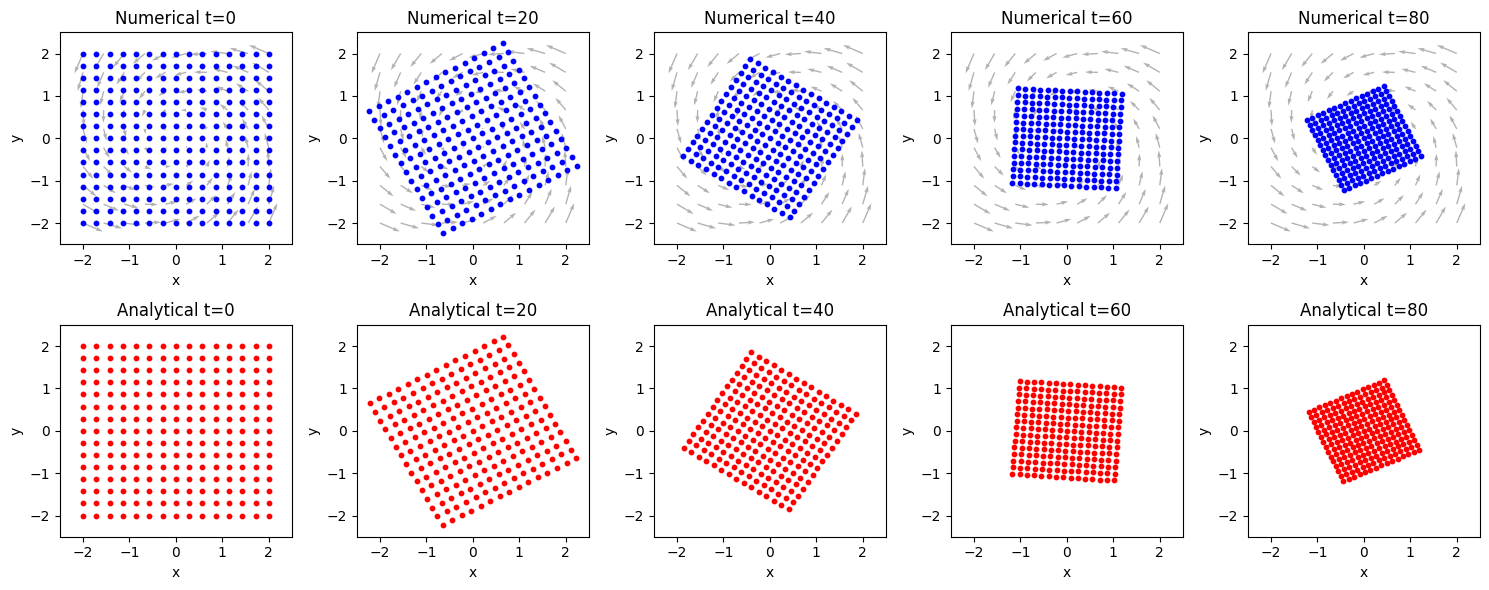

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define time-dependent velocity field
# This function returns the velocity components u, v at a given position (x, y) and time t
# The velocity field directs particles toward the origin (0,0) while also inducing rotation
def velocity_field(x, y, t):
    attraction_strength = 0.2  # Strength of attraction to the center
    rotation_strength = 0.5  # Strength of rotation

    u = -x * attraction_strength - y * rotation_strength  # x-component of velocity
    v = -y * attraction_strength + x * rotation_strength  # y-component of velocity

    return u, v

# Define analytical solution for particle motion
def analytical_solution(x0, y0, t):
    exp_term = np.exp(-0.2 * t)
    x_t = exp_term * (x0 * np.cos(0.5 * t) - y0 * np.sin(0.5 * t))
    y_t = exp_term * (x0 * np.sin(0.5 * t) + y0 * np.cos(0.5 * t))
    return x_t, y_t

# Initialize particle positions in a grid
num_particles = 15
x_vals = np.linspace(-2, 2, num_particles)
y_vals = np.linspace(-2, 2, num_particles)
x_grid, y_grid = np.meshgrid(x_vals, y_vals)
particles = np.vstack([x_grid.ravel(), y_grid.ravel()]).T  # Flatten grid to list of particle positions

# Time step for numerical integration
dt = 0.05  # Small time step for better accuracy
num_steps = 200  # Number of simulation steps

# Define time instances to capture for snapshot visualization
snapshot_times = list(range(0, 5))
snapshot_times = [x * 20 for x in snapshot_times]

# Create figure and axes for multiple time snapshots
fig, axes = plt.subplots(2, len(snapshot_times), figsize=(15, 6))

for i, t in enumerate(snapshot_times):
    # Compute numerical particle positions at time t
    temp_particles = particles.copy()  # Copy initial particle positions for each snapshot
    for step in range(t):  # Update particles iteratively over t time steps
        u, v = velocity_field(temp_particles[:, 0], temp_particles[:, 1], step)  # Get velocity at current positions
        temp_particles[:, 0] += u * dt  # Update x positions using Euler method
        temp_particles[:, 1] += v * dt  # Update y positions using Euler method

    # Compute analytical particle positions at time t
    analytical_x, analytical_y = analytical_solution(particles[:, 0], particles[:, 1], t * dt)

    # Plot velocity field at snapshot time t
    x_arrows, y_arrows = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    u_arrows, v_arrows = velocity_field(x_arrows, y_arrows, t)  # Get velocity vectors for quiver plot
    axes[0, i].quiver(x_arrows, y_arrows, u_arrows, v_arrows, color='gray', alpha=0.6)

    # Plot numerical particle positions at snapshot time t
    axes[0, i].scatter(temp_particles[:, 0], temp_particles[:, 1], color='b', s=10)
    axes[0, i].set_xlim(-2.5, 2.5)
    axes[0, i].set_ylim(-2.5, 2.5)
    axes[0, i].set_title(f"Numerical t={t}")
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")

    # Plot analytical particle positions at snapshot time t
    axes[1, i].scatter(analytical_x, analytical_y, color='r', s=10)
    axes[1, i].set_xlim(-2.5, 2.5)
    axes[1, i].set_ylim(-2.5, 2.5)
    axes[1, i].set_title(f"Analytical t={t}")
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")

plt.tight_layout()
plt.show()


# normal distribution to binomial distribution

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

###############################################################################
# 1. Define distributions: p0 = Normal(0,1), p1 = Binomial(n,p) on {0,...,n}
###############################################################################
# For simplicity, we do 1D Normal(0,1) and Binomial(n, p).

n = 2
p = 0.3

def sample_X0(batch_size):
    """
    Sample from the 1D normal distribution N(0,1).
    Returns a tensor of shape (batch_size,).
    """
    return torch.randn(batch_size)

import numpy as np

def sample_Y(batch_size, n=1, p=0.5):
    """
    Sample from a Binomial(n, p), returning values in {0, 1, ..., n}.
    The values are then mapped to two uniform distributions:
      - Values near 0 are mapped to Uniform(-0.1, 0.1)
      - Values near n are mapped to Uniform(0.9, 1.1)

    Parameters:
    - batch_size: Number of samples to generate.
    - n: Number of trials in the binomial distribution.
    - p: Probability of success in each trial.

    Returns:
    - Samples mapped to two disjoint uniform distributions.
    """
    # Sample from a Binomial distribution
    Y_raw = np.random.binomial(n=n, p=p, size=batch_size)

    # Create two regions
    X_1_a = np.random.uniform(low=-0.1, high=0.1, size=batch_size)
    X_1_b = np.random.uniform(low=0.9, high=1.1, size=batch_size)

    # Map Y_raw == 0 to X_1_a, Y_raw == n to X_1_b
    Y_mapped = np.where(Y_raw == 0, X_1_a, X_1_b)

    return torch.Tensor(Y_mapped)




###############################################################################
# 2. Define a simple velocity model v_theta(x, t)
###############################################################################
# We'll feed [x,t] into a small MLP that outputs a single velocity value in 1D.

class VelocityNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)  # 1D velocity output
        )
    def forward(self, x, t):
        # x, t are both shape (batch_size,)
        # Combine them into a 2D input [x, t].
        inp = torch.stack([x, t], dim=1)  # shape (batch_size, 2)
        return self.net(inp).squeeze(dim=1)  # shape (batch_size,)

###############################################################################
# 3. Instantiate model and define training loop (flow matching / trajectory matching)
###############################################################################
model = VelocityNet(hidden_dim=128)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

num_steps = 20000
batch_size = 1024

In [18]:
from tqdm import tqdm
loss_history = []

with tqdm(range(num_steps), desc="Training") as pbar:
    for step in pbar:
    # Sample from p0 and p1
        x0 = sample_X0(batch_size)  # shape (B,)
        y  = sample_Y(batch_size)   # shape (B,)

        # Sample times t ~ Uniform(0,1)
        t = torch.rand(batch_size)  # shape (B,)

        # Construct the interpolation: X_t = (1-t)*x0 + t*y
        x_t = (1 - t) * x0 + t * y

        # True velocity = d/dt of x_t = y - x0
        with torch.no_grad():
            true_vel = y - x0  # shape (B,)

        # Predicted velocity from model
        pred_vel = model(x_t, t)

        # Compute MSE loss
        loss = (pred_vel - true_vel).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.6f}")
        loss_history.append(loss.item())


Loss: 0.596784: 100%|██████████| 20000/20000 [04:42<00:00, 70.84it/s] 


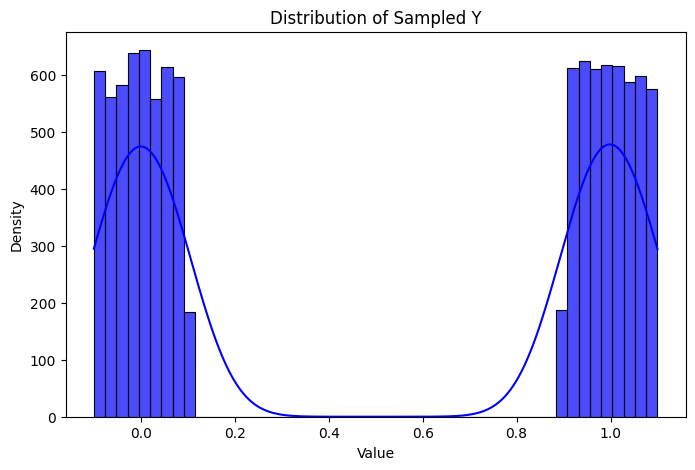

In [20]:
import seaborn as sns
batch_size = 10000
samples = sample_Y(batch_size=batch_size, n=1, p=0.5)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(samples, bins=50, kde=True, alpha=0.7, color='blue')
plt.title("Distribution of Sampled Y")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

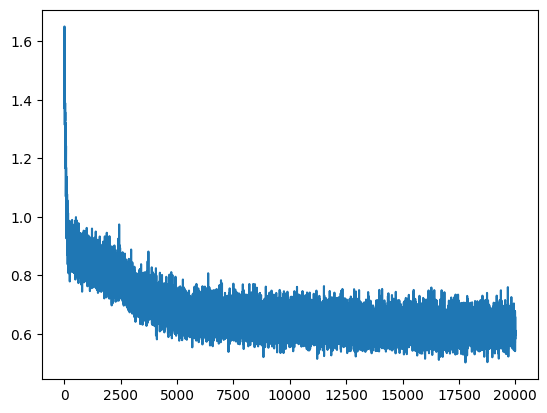

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

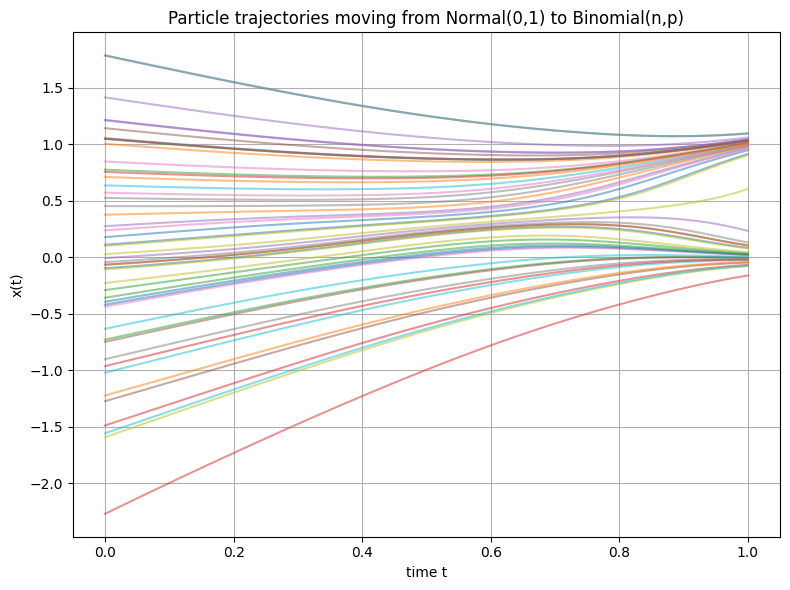

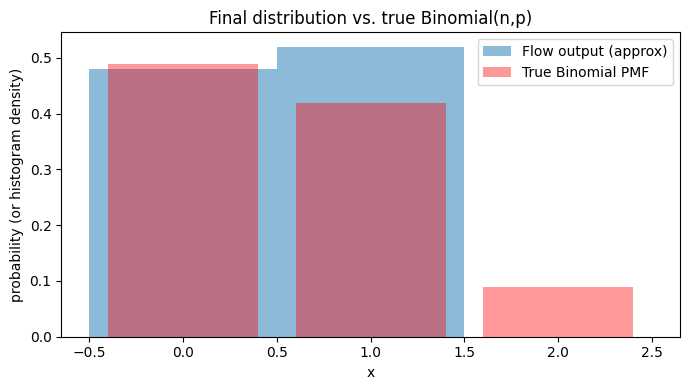

In [22]:


###############################################################################
# 4. Define a function to integrate the learned ODE from t=0 to t=1
#    for a given set of initial points x0
###############################################################################
def integrate_ode_flow(model, x0, n_steps=50):
    """
    Numerically integrate dx/dt = v_theta(x, t), from t=0 to t=1
    using Euler's method with n_steps steps.

    Args:
      model: the trained VelocityNet
      x0: initial samples, shape (B,)
      n_steps: how many Euler steps from t=0 to t=1
    Returns:
      trajectory: shape (n_steps+1, B)
        Each row is the positions of all particles at a given time step.
    """
    device = x0.device
    times = torch.linspace(0., 1., n_steps+1, device=device)
    dt = 1.0 / n_steps

    x = x0.clone()
    traj = [x0.clone()]  # store the initial positions at t=0
    for i in range(n_steps):
        t = times[i]
        v = model(x, t.expand_as(x))  # v_theta(x(t), t)
        x = x + dt * v
        traj.append(x.clone())
    return torch.stack(traj, dim=0)  # shape (n_steps+1, B)


###############################################################################
# 5. Visualize the particle movement over time [0,1]
###############################################################################
# We'll sample a small batch of particles from p0, then integrate the flow
# and plot their positions across time steps.

# Sample a smaller batch for visualization
vis_batch_size = 50
x0_vis = sample_X0(vis_batch_size)

# Integrate
trajectory = integrate_ode_flow(model, x0_vis, n_steps=50)
# trajectory.shape = (51, 50)

# Convert to numpy for plotting
trajectory_np = trajectory.detach().cpu().numpy()  # shape (51, 50)
time_grid = np.linspace(0, 1, 51)

# Let's show each particle's path in a single figure.
plt.figure(figsize=(8,6))
for i in range(vis_batch_size):
    plt.plot(time_grid, trajectory_np[:, i], alpha=0.5)
plt.xlabel("time t")
plt.ylabel("x(t)")
plt.title("Particle trajectories moving from Normal(0,1) to Binomial(n,p)")
plt.grid(True)
plt.tight_layout()
plt.show()


###############################################################################
# 6. (Optional) Compare final distribution to binomial visually
###############################################################################
final_x = trajectory[-1]  # shape (50,) final positions
final_x_np = final_x.detach().cpu().numpy()

# Let's do a histogram overlay
plt.figure(figsize=(7,4))

# Binomial distribution pmf for reference:
k_values = torch.arange(n+1)
binom_pmf = torch.distributions.Binomial(n, p).log_prob(k_values).exp().numpy()
binom_pmf /= binom_pmf.sum()  # just to be sure

plt.hist(final_x_np, bins=np.linspace(-0.5, n+0.5, n+2), density=True,
         alpha=0.5, label="Flow output (approx)")

plt.bar(k_values.numpy(), binom_pmf, width=0.8, alpha=0.4, color='r', label="True Binomial PMF")

plt.xlabel("x")
plt.ylabel("probability (or histogram density)")
plt.title("Final distribution vs. true Binomial(n,p)")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
y[0:3]

tensor([ 0.0759,  1.0892, -0.0678])